| pmgus.ipynb |
|-|
| "Pre-Market Gap-Up Screener" |

In [114]:
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
import vectorbt as vbt
from ta.trend import MACD

from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import SMAIndicator, MACD, PSARIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator
from datetime import datetime
from datetime import timedelta as td
import time
from tqdm import tqdm  # Visualize loop progress
from sklearn.linear_model import LinearRegression
from tenacity import retry, stop_after_attempt, wait_fixed
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
pd.set_option('display.colheader_justify', 'left')  # Left-align column headers
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
vbt.settings.set_theme('dark')
# vbt.settings.plotting.aut_rangebreaks = True

import requests
import json
import os
import pytz # timezone
import warnings

# LEVEL #0
| INITIAL DATA IMPORT |
|-|
| LEVEL #0 |

In [115]:
# base file path and file path setup
base_dir_path = '/Users/sudz4/Desktop/SPS_local/sps/x_pre_market_gap_up_screener/' 
std_file_name_str = 'tv_screen_gap-up_'

#####---------------------#####
# screen_date = '2024-11-15' #----> $RSI
# screen_date = '2024-11-20' #----> $RSI, $ADMA
screen_date = '2024-11-21' #----> $MARA
#####---------------------#####

file_type = '.csv'
filename = base_dir_path + std_file_name_str + screen_date + file_type

# read the csv file
print(filename)
trading_view_df = pd.read_csv(filename)
print(len(trading_view_df))
# print first 5 ticker Symbols only
print(trading_view_df['Symbol'].head(5))

/Users/sudz4/Desktop/SPS_local/sps/x_pre_market_gap_up_screener/tv_screen_gap-up_2024-11-21.csv
1630
0    NVDA
1    AAPL
2    MSFT
3    AMZN
4    META
Name: Symbol, dtype: object


# LEVEL #1
| PRIMARY SCREENING |
|-|
| LEVEL #1 |

In [116]:
def categorize_market_cap(df):
    """Categorize stocks based on market capitalization."""
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    conditions = [
        (df['Market capitalization'] >= 200_000_000_000),  # Titans
        (df['Market capitalization'] >= 10_000_000_000) & (df['Market capitalization'] < 200_000_000_000),  # Large caps
        (df['Market capitalization'] >= 2_000_000_000) & (df['Market capitalization'] < 10_000_000_000),  # Mid caps
        (df['Market capitalization'] >= 300_000_000) & (df['Market capitalization'] < 2_000_000_000),  # Small caps
        (df['Market capitalization'] > 50_000_000) & (df['Market capitalization'] < 300_000_000),  # Micro caps
        (df['Market capitalization'] <= 50_000_000)  # Shrimp
    ]
    categories = ['Titans', 'Large caps', 'Mid caps', 'Small caps', 'Micro caps', 'Shrimp']
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    return df

# execute categorization
category_setup_df = categorize_market_cap(trading_view_df).copy()

# drop Undefined marketCapType
category_setup_df = category_setup_df[category_setup_df['marketCapType'] != 'Undefined']

# convert necessary columns to numeric
def convert_columns_to_numeric(df, columns):
    """Convert specified columns to numeric types."""
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# list of columns to convert
numeric_columns = [
    'Market capitalization', 'Float shares outstanding', 'Relative Volume 1 day',
    'Relative Volume at Time', 'Pre-market Change %', 'Pre-market Gap %',
    'Price', 'Volume Weighted Average Price 1 day', 'Volatility 1 day',
    'Volatility 1 week', 'Volatility 1 month', 'Pre-market Volume'
]

# Apply conversion
category_setup_df = convert_columns_to_numeric(category_setup_df, numeric_columns)

# Criteria configuration for each market cap category
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # 0.2% for Titans
        "float_shares_outstanding_threshold": 1_000_000_000,  # 1 billion shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": 0.03,
        "pre_market_gap_percentage_threshold": 0.001,  # 0.1%
        "pre_market_vwap_drawdown_threshold": 0.003,  # 0.3% drawdown from VWAP
        "pre_market_volume_threshold": 50_000  # Minimum pre-market volume
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # 200 million shares
        "relative_volume_threshold": 1.3,  # More inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # 0.5%
        "pre_market_vwap_drawdown_threshold": 0.004,  # 0.4% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    # "Midlers" in TradingView
    "Midlers": { 
        "pre_market_change_pct_threshold": 0.02,  # 2% for Midlers 
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.02,
        "pre_market_vwap_drawdown_threshold": 0.005,  # 0.5% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.03,
        "pre_market_vwap_drawdown_threshold": 0.006,  # 0.6% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.04,
        "pre_market_vwap_drawdown_threshold": 0.007,  # 0.7% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.05,
        "pre_market_vwap_drawdown_threshold": 0.008, # 0.8% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    }
}

def filter_stocks(df, config):
    """Filter stocks based on configuration criteria."""
    conditions = (
        (df['Pre-market Change %'] >= config.get('pre_market_change_pct_threshold', 0)) &
        (df['Float shares outstanding'] <= config.get('float_shares_outstanding_threshold', float('inf'))) &
        (df['Relative Volume 1 day'] >= config.get('relative_volume_threshold', 0)) &
        (df['Relative Volume at Time'] >= config.get('relative_volume_at_time_threshold', 0)) &
        (df['Pre-market Gap %'] >= config.get('pre_market_gap_percentage_threshold', 0)) &
        (df['Price'] >= df['Volume Weighted Average Price 1 day'] * (1 - config.get('pre_market_vwap_drawdown_threshold', 0))) &
        (df['Volatility 1 day'] >= df['Volatility 1 week']) &
        (df['Volatility 1 day'] >= df['Volatility 1 month']) &
        (df['Pre-market Volume'] >= config.get('pre_market_volume_threshold', 0))
    )
    return df[conditions]

def screen_stocks_by_category(df, category):
    """Filter stocks in a category using predefined criteria."""
    config = criteria_config.get(category, {})
    filtered_df = filter_stocks(df, config)
    return filtered_df

# execute filtering
smash_df = pd.DataFrame()
categories = category_setup_df['marketCapType'].unique()

for category in categories:
    category_df = category_setup_df[category_setup_df['marketCapType'] == category]
    gap_up_stage_df = screen_stocks_by_category(category_df, category)
    smash_df = pd.concat([smash_df, gap_up_stage_df], ignore_index=True)

# add 'Market capitalization' to the reordered columns list
cols_list = [
    'Symbol', 
    'Description', 
    'marketCapType', 
    'Pre-market Change %', 
    'Pre-market Gap %', 
    'marketCapType',
    'Market capitalization',
    'Price', 
    'Pre-market Open', 
    'Industry', 
    'Index', 
    'Sector', 
    'Exchange',
    'Recent earnings date', 
    'Upcoming earnings date', 
    'Float shares outstanding', 
    'Average Volume 10 days',
    'Average Volume 30 days', 
    'Average Volume 90 days',
    'Relative Volume 1 day', 
    'Relative Volume 5 minutes', 
    'Relative Volume 30 minutes', 
    'Relative Volume at Time', 
    'Analyst Rating'
]

# filter columns to only include those present in the DataFrame
existing_cols = [col for col in cols_list if col in smash_df.columns]
smash_df = smash_df[existing_cols]

# sort and reset index
smash_df = smash_df.sort_values(
    by=['Pre-market Change %', 'Price'],
    ascending=[False, False]).reset_index(drop=True)

print(f"{smash_df.shape[0]} stockes found in the screener.")
# ## ISSUE ##
# #### HARD CODED FILE PATH ####
# # also change this if you add another level, you probably will to screener_smoke 
# # output_filename = f'pre_market_gap_up_screener_targets_{today_date_str}.csv'
# output_filename = f'/Users/sudz4/Desktop/BOOK-II/nowbear/stgy_pm-gap-up-screener/data_pmgus/output_pmgus/pre_market_gap_up_screener_targets_2024-09-26.csv'

# smash_df.to_csv(output_filename, index=False)

35 stockes found in the screener.


In [117]:
# display(smash_df.head(4))
print(len(smash_df))
print(smash_df)

35
   Symbol Description                         marketCapType  \
0   SMLR              Semler Scientific, Inc.  Small caps     
1   MARA                  MARA Holdings, Inc.    Mid caps     
2   SRAD                  Sportradar Group AG    Mid caps     
3     BJ   BJ's Wholesale Club Holdings, Inc.  Large caps     
4   LMND                       Lemonade, Inc.    Mid caps     
5     KD               Kyndryl Holdings, Inc.    Mid caps     
6    GAP                      Gap, Inc. (The)    Mid caps     
7    RRC          Range Resources Corporation    Mid caps     
8   CORZ                Core Scientific, Inc.    Mid caps     
9     ZI           ZoomInfo Technologies Inc.    Mid caps     
10   CRK             Comstock Resources, Inc.    Mid caps     
11  GERN                    Geron Corporation    Mid caps     
12    QS             QuantumScape Corporation    Mid caps     
13  IMVT                     Immunovant, Inc.    Mid caps     
14  SMPL        The Simply Good Foods Company    Mid

| TECHNICAL ANALYSIS |
|-|
| LEVEL #2 |

RVOL retriever ????

In [118]:
import yfinance as yf
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator

In [119]:
print(screen_date)

2024-11-21


fix all this shit. yahoo will give you close. 
you get pre-market from tradingview (0615?)

In [120]:
def technical_screen(df, test_date, lookback_period=100):
    """
    Calculate technical indicators using TA library and apply filters for a specific date.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing stock symbols
    test_date (str): Date to test in 'YYYY-MM-DD' format
    lookback_period (int): Number of days to look back for calculating indicators
    
    Returns:
    pd.DataFrame: DataFrame with technical indicators and filtered results
    """
    # Calculate start date for historical data
    start_date = (datetime.strptime(test_date, '%Y-%m-%d') - 
                 timedelta(days=lookback_period)).strftime('%Y-%m-%d')
    end_date = (datetime.strptime(test_date, '%Y-%m-%d') + 
                timedelta(days=1)).strftime('%Y-%m-%d')
    
    symbols = df['Symbol'].tolist()
    technical_data = []
    
    for symbol in symbols:
        try:
            # Get historical data
            ticker = yf.Ticker(symbol)
            hist = ticker.history(start=start_date, end=end_date, interval='1d')
            
            if not hist.empty:
                # Calculate indicators using TA library
                close_prices = hist['Close']
                
                # RSI
                rsi = RSIIndicator(close=close_prices, window=14)
                hist['RSI'] = rsi.rsi()
                
                # Moving Averages
                sma5 = SMAIndicator(close=close_prices, window=5)
                sma20 = SMAIndicator(close=close_prices, window=20)
                sma50 = SMAIndicator(close=close_prices, window=50)
                macd = MACD(close=close_prices)

                hist['MA5'] = sma5.sma_indicator()
                hist['MA20'] = sma20.sma_indicator()
                hist['MA50'] = sma50.sma_indicator()
                hist['MACD'] = macd.macd()
                
                # Get most recent values
                current_price = hist['Close'].iloc[-1]
                current_rsi = hist['RSI'].iloc[-1]
                current_ma5 = hist['MA5'].iloc[-1]
                current_ma20 = hist['MA20'].iloc[-1]
                # add ma50
                current_ma50 = hist['MA50'].iloc[-1]
                current_macd = hist['MACD'].iloc[-1]
                
                technical_data.append({
                    'Symbol': symbol,
                    'yahooPrice': current_price,
                    'RSI': current_rsi,
                    'MA5': current_ma5,
                    'MA20': current_ma20,
                    'MA50': current_ma50,
                    'MACD': current_macd,
                    'Volume': hist['Volume'].iloc[-1],
                    # add curret volume ???? data source ????
                    # 'RVOL8': hist['Volume'].iloc[-1] / hist['Volume'].rolling(8).mean().iloc[-1],
                    'Date': hist.index[-1]
                })
                
        except Exception as e:
            print(f"Error processing {symbol}: {str(e)}")
            continue
    
    result_df = pd.DataFrame(technical_data)
    return result_df


In [121]:
explode_df = technical_screen(smash_df, screen_date)

explode_df

,Symbol,yahooPrice,RSI,MA5,MA20,MA50,MACD,Volume,Date
0,SMLR,66.430000,79.703347,52.746000,41.422500,31.708000,7.454644,3289100,2024-11-21 00:00:00-05:00
1,MARA,24.180000,62.423140,21.170000,19.715000,17.832200,1.299205,165681000,2024-11-21 00:00:00-05:00
2,SRAD,17.495001,82.494382,17.306000,14.858250,13.275800,1.387441,881100,2024-11-21 00:00:00-05:00
3,BJ,92.790001,68.483546,87.779999,87.339501,85.530200,0.838621,5782200,2024-11-21 00:00:00-05:00
4,LMND,50.360001,88.471846,40.938000,29.519500,22.359400,6.361986,9905700,2024-11-21 00:00:00-05:00
5,KD,32.490002,84.124630,29.008001,26.265500,24.784000,1.530085,6790900,2024-11-21 00:00:00-05:00
6,GAP,22.040001,54.471205,21.308001,21.568000,21.264165,0.001828,19902000,2024-11-21 00:00:00-05:00
7,RRC,35.570000,72.364268,34.552000,32.672000,31.478800,1.110609,3594000,2024-11-21 00:00:00-05:00
8,CORZ,17.549999,68.006929,16.542000,15.207500,13.525000,1.074078,10506500,2024-11-21 00:00:00-05:00
9,ZI,10.370000,46.182665,10.166000,11.037000,10.553400,-0.045314,17097500,2024-11-21 00:00:00-05:00


In [122]:
[print(smash_df.columns)]

Index(['Symbol', 'Description', 'marketCapType', 'Pre-market Change %',
       'Pre-market Gap %', 'marketCapType', 'Market capitalization', 'Price',
       'Pre-market Open', 'Industry', 'Index', 'Sector', 'Exchange',
       'Recent earnings date', 'Upcoming earnings date',
       'Float shares outstanding', 'Average Volume 10 days',
       'Average Volume 30 days', 'Average Volume 90 days',
       'Relative Volume 1 day', 'Relative Volume 5 minutes',
       'Relative Volume 30 minutes', 'Relative Volume at Time',
       'Analyst Rating'],
      dtype='object')


[None]

In [123]:
# merge join the two dataframes
explode_df = pd.merge(smash_df[['Symbol', 
                                'Description', 
                                'marketCapType', 
                                'Pre-market Change %', 
                                'Pre-market Gap %', 
                                'Market capitalization', 
                                'Price', 'Pre-market Open', 
                                'Relative Volume 5 minutes', 
                                'Industry']], explode_df, on='Symbol', how='inner')


print(len(explode_df))
print(len(explode_df.columns))
display(explode_df.head(3))

35
19


,Symbol,Description,marketCapType,marketCapType,Pre-market Change %,Pre-market Gap %,Market capitalization,Price,Pre-market Open,Relative Volume 5 minutes,Industry,yahooPrice,RSI,MA5,MA20,MA50,MACD,Volume,Date
0,SMLR,"Semler Scientific, Inc.",Small caps,Small caps,27.349418,11.726000,4.306702e+08,59.270,66.22,1.502335,Medical specialties,66.430000,79.703347,52.746,41.42250,31.7080,7.454644,3289100,2024-11-21 00:00:00-05:00
1,MARA,"MARA Holdings, Inc.",Mid caps,Mid caps,11.533363,8.351745,7.283047e+09,22.630,24.52,2.085263,Data processing services,24.180000,62.423140,21.170,19.71500,17.8322,1.299205,165681000,2024-11-21 00:00:00-05:00
2,SRAD,Sportradar Group AG,Mid caps,Mid caps,4.144041,2.029151,5.216332e+09,17.495,17.85,7.940331,Packaged software,17.495001,82.494382,17.306,14.85825,13.2758,1.387441,881100,2024-11-21 00:00:00-05:00


In [124]:
# export to csv
targets_data_fn = f'/Users/sudz4/Desktop/SPS_local/sps/x_pre_market_gap_up_screener/output_pmgus_{screen_date}.csv'
explode_df.to_csv(targets_data_fn, index=False)

# display(explode_df)

operations-START

# LEVEL [-1] or [-2] (END (or near the END))
| FINAL MOMENTUM SCREENER (& filter conditions) |
|-|
| LEVEL #[-1] or 2nd to last |

In [125]:
def final_momentum_filter(df):
    """
    Final filter for high-probability morning momentum trades
    """
    return df[
        # Strong pre-market movement but not overextended
        (
            (df['Pre-market Change %'] > 3.0) |
            ((df['Pre-market Change %'] > 1.5) & (df['Relative Volume 5 minutes'] > 5.0))
        ) &
        
        # Volume validation
        (df['Relative Volume 5 minutes'] > 2.0) &
        
        # Industry/sector grouping
        (df.groupby('Industry')['Pre-market Change %'].transform('count') > 1)
    ].sort_values('Pre-market Change %', ascending=False).head(3)

In [126]:
final_momentum_targets_quick_df = final_momentum_filter(explode_df)

In [127]:
print(len(final_momentum_targets_quick_df))
# print(final_momentum_targets_quick_df)
display(final_momentum_targets_quick_df)

3


,Symbol,Description,marketCapType,marketCapType,Pre-market Change %,Pre-market Gap %,Market capitalization,Price,Pre-market Open,Relative Volume 5 minutes,Industry,yahooPrice,RSI,MA5,MA20,MA50,MACD,Volume,Date
1,MARA,"MARA Holdings, Inc.",Mid caps,Mid caps,11.533363,8.351745,7.283047e+09,22.630,24.52,2.085263,Data processing services,24.180000,62.423140,21.170000,19.71500,17.8322,1.299205,165681000,2024-11-21 00:00:00-05:00
2,SRAD,Sportradar Group AG,Mid caps,Mid caps,4.144041,2.029151,5.216332e+09,17.495,17.85,7.940331,Packaged software,17.495001,82.494382,17.306000,14.85825,13.2758,1.387441,881100,2024-11-21 00:00:00-05:00
5,KD,"Kyndryl Holdings, Inc.",Mid caps,Mid caps,2.173151,1.121626,6.626690e+09,28.530,28.85,5.693666,Data processing services,32.490002,84.124630,29.008001,26.26550,24.7840,1.530085,6790900,2024-11-21 00:00:00-05:00


operations-END

# DATA ENRICHMENT
| ENRICH DATA with other data sources |
|-|
| Enrich and augment the dataframe |

# Perfomance Testing
| Perfomance Testing (after market close for DAY)|
|-|
| test the performance of the earlier selected target PMGU stock |

In [134]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [145]:
def plot_daily_price(symbol, date_str):
    """
    Plot stock price action for a single trading day
    
    Parameters:
    symbol (str): Stock ticker
    date_str (str): Date in YYYY-MM-DD format
    """
    # Get data
    start_date = pd.to_datetime(date_str)
    end_date = start_date + timedelta(days=1)
    
    # Download 1-minute data
    ticker = yf.Ticker(symbol)
    df = ticker.history(start=start_date, end=end_date, interval='1m')
    
    # Create figure and axis with dark theme
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot price
    ax.plot(df.index, df['Close'], color='white', linewidth=1)
    
    # # Add VWAP
    # df['Cumulative_PV'] = (df['Close'] * df['Volume']).cumsum()
    # df['Cumulative_Volume'] = df['Volume'].cumsum()
    # df['VWAP'] = df['Cumulative_PV'] / df['Cumulative_Volume']
    # ax.plot(df.index, df['VWAP'], color='purple', alpha=0.7, linestyle='--', label='VWAP')
    
    # Format x-axis for time
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45)
    
    # Add title and labels
    plt.title(f'{symbol} Price Action on {date_str}', color='white', pad=20)
    plt.ylabel('Price ($)', color='white')
    
    # Add grid
    ax.grid(True, alpha=0.2)
    
    # Add entry price reference line
    entry_price = 22.63
    ax.axhline(y=entry_price, color='yellow', linestyle='--', alpha=0.5, label='Entry Price')
    
    # Add legend
    plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()

In [146]:
target_ticker_str  = final_momentum_targets_quick_df['Symbol'].values[0]
print(target_ticker_str)
print(screen_date)

MARA
2024-11-21


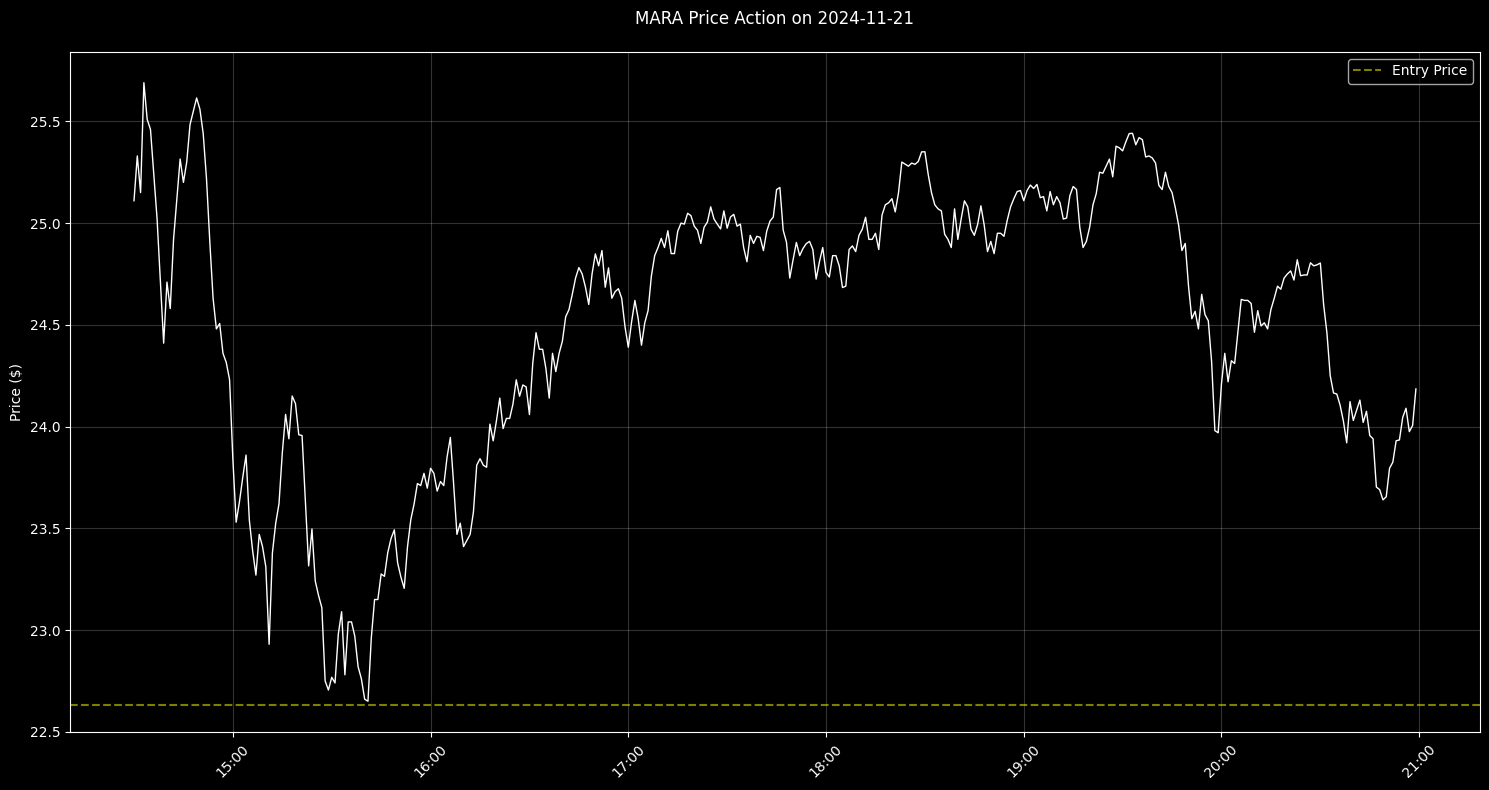

In [147]:
# EXECUTE for TARGET ticker symbol (1)
plot_daily_price(target_ticker_str, screen_date)

-MARA ($22.63)
Up 11.53% pre-market
Strong crypto-sector momentum
High relative volume (2.08x)
Price Point: Good for larger share size
Day's Targets: R1 = $23.50, R2 = $24.50

-MARA (60%): $48,000
Entry: $22.63
Share Count: 2,120 shares
Target Return (R2): $4,000 (+8.3% to $24.50)
Stop: $22.15 (-$1,017 risk)

In [ ]:
#### new df called tt_perf_df
### 1D, 1m, 5m, 15m price to df
## date range for gap up use case relevance?










In [ ]:
#### plot the near time but historical data (usually from TODAY)
### should be doing this in the evening i.e., 2200
## smooth lines, not candlesticks
# use scipy? or the TradingView open source 
# maybe want to use TV osource later on, i remember static limitations ?







In [ ]:
#### export from fidelity
### import and clean for only PMGUS
## new df called tt_trades_history_df

In [ ]:
#### plot the trade buy and sell points on the same chart







# END OF WORKING CODE
# END OF WORKING CODE
# END OF WORKING CODE
# END OF WORKING CODE

In [ ]:
# def technical_screen_filter(df):
#     """
#     Pre-market momentum filter focused on 634-704 EST trading window
#     """
#     df = df[
#         # RSI not overbought but showing strength
#         (df['RSI'] >= 20) & (df['RSI'] < 64) &
#         (df['MACD'] > 0.05)
#         (df['Relative Volume 5 minutes'] > 2)
#         # # Price vs MA relationship for pre-market
#         # ((df['Pre-market Open'] > df['MA5'])
#         #  # OR consolidating near MA5 with volume
#         #  ((df['Pre-market Open'] >= df['MA5'] * 0.985) & 
#         #   (df['Relative Volume 5 minutes'] > 1.5))) &
        
#         # # Volume validation
#         # (df['Volume'] > df['Volume'].rolling(5).mean() * 1.2)
#     ]
#     return df

In [ ]:
# ts_filt_df = technical_screen_filter(explode_df)

# print(len(ts_filt_df))
# display(ts_filt_df.head(3))
# # print(explode_df)

# DEVELOPEMENT
## testing the yahoo finance API
### retrieving MOST RECENT ticker data AND similar data BUT with a SPECIFIC DATE
#### useful for backtesting later and inflight developement testing

In [ ]:
# # testing yahoo finance api
# ## most recent
# ticker = "ADMA"
# data = yf.download(ticker, period="1d")

# print(data)

In [ ]:
# # testing retrieval
# ## specific date
# specific_date = "2024-11-11"

# # Download the data for the specific date
# data_sd = yf.download(ticker, start=specific_date, end=(datetime.strptime(specific_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d'))

# # Print the data
# print(data_sd)

| LEVEL #3 - SCREENER |
|-|
| xxx |

# DEVELOPEMENT

old but fresh still good code use this 

In [ ]:
# # printing raw to dictionary to inspect
# # Get ticker object
# ticker = yf.Ticker('ADMA')

# # Print raw info dictionary
# print("\nRaw Info Dictionary:")
# for key, value in ticker.info.items():
#     print(f"{key}: {value}")

# # # Show available attributes/methods
# # print("\nAvailable attributes/methods:")
# # for method in dir(ticker):
# #     if not method.startswith('_'):
# #         print(method)

In [ ]:
# # return smash_list of Symbols
# smash_list = smash_df['Symbol'].tolist()


# print(len(smash_df))
# print(len(smash_list))
# print(smash_list)


return current stock price

"quick back test"
which tickers from smash_list did well on today
1-baseline buy sell w/same time b/s
2-dynamic sell same buy

1-specific day to back test
2-move code over for specific times
3-baseline times
4-other ideas time segments
5-dynamic buy windows IF only?

In [ ]:
# start----quick back test function
print(screen_date)

2024-11-21


In [ ]:
from datetime import datetime

# Use datetime.strptime() where needed

In [ ]:
# ####---quick start back tests
# def quick_backtest(df, day):
#     symbols = df['Symbol'].tolist()
#     stock_data = {}

#     for symbol in symbols:
#         ticker = yf.Ticker(symbol)
#         qbt_data = ticker.history(start=day, end=(datetime.strptime(day, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d'), interval='1m')

#         if not qbt_data.empty:
#             stock_data[symbol] = {
#                 'High': qbt_data['High'].values[0],
#                 'Low': qbt_data['Low'].values[0],
#                 'Open': qbt_data['Open'].values[0],
#                 'Close': qbt_data['Close'].values[0],
#                 'Volume': qbt_data['Volume'].values[0],
#                 'Date': qbt_data.index[0]
#             }
#         else:
#             qbt_data[symbol] = {
#                 'High': None,
#                 'Low': None,
#                 'Open': None,
#                 'Close': None,
#                 'Volume': None,
#                 'Date': None
#             }

#     qbt_stg_df = pd.DataFrame(qbt_data).T.reset_index().rename(columns={'index': 'Symbol'})
    
#     ####

#     return qbt_stg_df

In [ ]:
# # execute
# print(screen_date)

old code

In [ ]:
# # add high low close
# #### ---- Quick Stary Backtesting ---- ####
# def basic_daily_technicals(df):
#     symbols = df['Symbol'].tolist()
#     stock_data = {}

#     for symbol in symbols:
#         stock_info = yf.Ticker(symbol)
#         today_data = stock_info.history(period='1d')
        
#         if not today_data.empty:
#             stock_data[symbol] = {
#                 'High': today_data['High'].values[0],
#                 'Low': today_data['Low'].values[0],
#                 'Open': today_data['Open'].values[0],
#                 'Close': today_data['Close'].values[0],
#                 'Volume': today_data['Volume'].values[0],
#                 'Date': today_data.index[0]
#             }
#         else:
#             stock_data[symbol] = {
#                 'High': None,
#                 'Low': None,
#                 'Open': None,
#                 'Close': None,
#                 'Volume': None,
#                 'Date': None
#             }

#     # create a DataFrame from the stock data dictionary
#     stock_data_df = pd.DataFrame(stock_data).T.reset_index().rename(columns={'index': 'Symbol'})
    
#     # merge the new stock data with the existing DataFrame
#     updated_df = pd.merge(df, stock_data_df, on='Symbol', how='left')
    
#     return updated_df

In [ ]:
# smash_two_df =  basic_daily_technicals(smash_df)

| LEVEL #2 - SCREENER |
|-|
| TECHNICAL INDICATORS - via yahoo finance |

*note yahoo finance data source transition
*feels like this is more of a swing screen????

In [ ]:
# import yfinance as yf

# from ta.trend import MACD
# from ta.momentum import RSIIndicator
# from ta.trend import SMAIndicator
# from ta.momentum import RSIIndicator, StochasticOscillator
# from ta.trend import SMAIndicator, MACD, PSARIndicator
# from ta.volatility import BollingerBands, AverageTrueRange
# from ta.volume import OnBalanceVolumeIndicator
# # import vectorbt as vbt
# # vbt.settings.set_theme('dark')


In [ ]:
# import yfinance as yf
# import pandas as pd
# from ta.momentum import RSIIndicator
# from ta.trend import SMAIndicator, MACD

need to add start date as a var for retroactive testing / backtesting

In [ ]:
# def compute_technical_indicators(df):
#     tech_data = []

#     for symbol in df['Symbol'].unique():
#         data = yf.download(symbol, period="6mo", interval="1d")

#         if not data.empty:
#             close_prices = data['Close'].squeeze()  # Ensure it's a 1-dimensional series
#             rsi = RSIIndicator(close_prices, window=14).rsi().iloc[-1] # last value!
#             ma20 = SMAIndicator(close_prices, window=20).sma_indicator().iloc[-1] # last value!
#             ma50 = SMAIndicator(close_prices, window=50).sma_indicator().iloc[-1] # last value!
#             macd = MACD(close_prices).macd_diff().iloc[-1] # last value!

#             tech_data.append({
#                 'Symbol': symbol,
#                 'RSI': rsi,
#                 'MA20': ma20,
#                 'MA50': ma50,
#                 'MACD': macd,
#                 'Yahoo Price': close_prices.iloc[-1], # last value! (price from Yahoo!)
#             })

#     tech_df = pd.DataFrame(tech_data)
#     return tech_df

note the last value because,
technically for back testing you want to pay attention here.
real time go time i think we want it most recent. meaning yesterday
if we are making decisions and in pre-market trading hours based on the Close from yesterday
yesterday = last Close $

In [ ]:
# explode_df = compute_technical_indicators(smash_df)

# print(explode_df.shape)
# print(explode_df.head())

In [ ]:
# print(explode_df.shape)
# print(explode_df.head())

# print(smash_df.shape)
# print(smash_df.iloc[:5,:3])

In [ ]:
# def screen_stocks_by_technical_indicators(df):
#     # filter based on RSI, MA, and MACD
#     df = df[(df['RSI'] >= 0) & (df['RSI'] < 70)]  # RSI filter condition
#     df = df[df['Yahoo Price'] > df['MA20']]
#     df = df[df['Yahoo Price'] > df['MA50']]
#     df = df[df['MACD'] > 0]
#     """ 
#     # should i add more to this?
#     # level 3 will start to get more advanced filering
#     # dont want to overfilter to soon also and miss something
#     # patience
#     """
#     return df

In [ ]:
# explode_df = screen_stocks_by_technical_indicators(explode_df)

# print(len(explode_df))
# print(explode_df.head())

In [ ]:
# # return explode_list of Symbols
# explode_list = explode_df['Symbol'].tolist()


# print(len(smash_df))
# print()

# print(len(explode_df))
# print(len(explode_list))
# print(explode_list)

In [ ]:
# print(explode_df)

In [ ]:
# print(screen_date)

In [ ]:
# # sory descending by RSI
# explode_df = explode_df.sort_values(by='RSI', ascending=True)

# print(explode_df)

| LEVEL #3 - SCREENER |
|-|
| xxx |

i think this is the place for those small tactical screeners
maybe even think about deploying dynamically for instance one above this ta technical screener filter
different days, different vols, and volatilty

see index specific
see vix
companies in same industry, same sector, same location? 

| LEVEL #4 - SCREENER |
|-|
| xxx |

could think about doing additional available (but separate now) on the subset, additional technical indicators from ta library

In [ ]:
# from ta.momentum import RSIIndicator, StochasticOscillator
# from ta.trend import SMAIndicator, MACD, CCIIndicator
# from ta.volatility import BollingerBands
# from ta.volume import OnBalanceVolumeIndicator
# from ta.volatility import AverageTrueRange

In [ ]:
# def compute_additional_indicators(df):
#     additional_data = []

#     for symbol in df['Symbol'].unique():
#         data = yf.download(symbol, period="6mo", interval="1d")

#         if not data.empty:
#             close_prices = data['Close'].squeeze()  # Ensure it's a 1-dimensional series
#             high_prices = data['High'].squeeze()
#             low_prices = data['Low'].squeeze()
#             volume = data['Volume'].squeeze()

#             # Compute additional indicators
#             bb = BollingerBands(close_prices)
#             atr = AverageTrueRange(high=high_prices, low=low_prices, close=close_prices)
#             stoch = StochasticOscillator(close=close_prices, high=high_prices, low=low_prices)
#             obv = OnBalanceVolumeIndicator(close=close_prices, volume=volume)
#             cci = CCIIndicator(high=high_prices, low=low_prices, close=close_prices)

#             additional_data.append({
#                 'Symbol': symbol,
#                 'Bollinger High': bb.bollinger_hband().iloc[-1],
#                 'Bollinger Low': bb.bollinger_lband().iloc[-1],
#                 'ATR': atr.average_true_range().iloc[-1],
#                 'Stochastic Oscillator': stoch.stoch().iloc[-1],
#                 'OBV': obv.on_balance_volume().iloc[-1],
#                 'CCI': cci.cci().iloc[-1],
#             })

#     additional_df = pd.DataFrame(additional_data)
#     return additional_df

In [ ]:
# double_explode_df = compute_additional_indicators(explode_df)

# print(len(explode_df))
# print(len(double_explode_df))

In [ ]:
# double_explode_df

In [ ]:
# def filter_additional_indicators(df):
#     # Example filter criteria
#     filtered_df = df[
#         (df['Stochastic Oscillator'] < 20) &  # Stochastic Oscillator indicates oversold
#         (df['CCI'] < -100) &  # CCI indicates oversold
#         (df['ATR'] > 1)  # ATR indicates high volatility
#     ]
#     return filtered_df

In [ ]:
# filtered_double_explode_df = filter_additional_indicators(double_explode_df)


# print(len(explode_df))
# print(len(filtered_double_explode_df))

| LEVEL #5,#6 - SCREENER |
|-|
| (mini) tight screeners - (toggle on and off w/comments?) |

return index data for relevant?
good time to see if that chart works opensource similar to tradingview

could also plot historical data for 53 stocks who cares. check it out on same chart?
watch a youtube
restart as new feature 

what about news
what about europe /asia price action
market and industry?

| Notes |
|-|
| END of WORKING CODE |

In [ ]:
# # read data file from TradingView to pandas df
# """ 
# Market : US
# Exchange : NASDAQ, NYSE
# Pre-market Chg > $0.00 USD

# Stocks = ~1100
# """
# base_file_path = '/Users/sudz4/Desktop/SPS_local/sps/x_pre_market_gap_up_screener/'
# file_name =  'tv_screen_gap-up_2024-10-29.csv'
# pmgus_df = pd.read_csv(base_file_path + file_name)


# print(len(pmgus_df))
# pmgus_df.tail(2)

In [ ]:
# def categorize_market_cap(df):
#     """Categorize stocks based on market capitalization."""
#     df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
#     conditions = [
#         (df['Market capitalization'] >= 200_000_000_000),  # Titans
#         (df['Market capitalization'] >= 10_000_000_000) & (df['Market capitalization'] < 200_000_000_000),  # Large caps
#         (df['Market capitalization'] >= 2_000_000_000) & (df['Market capitalization'] < 10_000_000_000),  # Mid caps
#         (df['Market capitalization'] >= 300_000_000) & (df['Market capitalization'] < 2_000_000_000),  # Small caps
#         (df['Market capitalization'] > 50_000_000) & (df['Market capitalization'] < 300_000_000),  # Micro caps
#         (df['Market capitalization'] <= 50_000_000)  # Shrimp
#     ]
#     categories = ['Titans', 'Large caps', 'Mid caps', 'Small caps', 'Micro caps', 'Shrimp']
#     df['marketCapType'] = np.select(conditions, categories, default='Undefined')
#     # drop Undefined
#     df = df[df['marketCapType'] != 'Undefined']
#     # convert to numeric the Market capitalization column
#     df['Market capitalization'] = pd.to_numeric(df['Market capitalization'])
    
#     return df

In [ ]:
# # APPLY - categorize market cap
# pmgus_df = categorize_market_cap(pmgus_df).copy()
# print(len(pmgus_df))


In [ ]:
# # convert necessary columns to numeric
# def convert_columns_to_numeric(df, columns):
#     """Convert specified columns to numeric types."""
#     for col in columns:
#         df[col] = pd.to_numeric(df[col], errors='coerce')
#     return df

# # list of columns to convert
# numeric_columns = [
#     'Market capitalization', 'Float shares outstanding', 'Relative Volume 1 day',
#     'Relative Volume at Time', 'Pre-market Change %', 'Pre-market Gap %',
#     'Price', 'Volume Weighted Average Price 1 day', 'Volatility 1 day',
#     'Volatility 1 week', 'Volatility 1 month', 'Pre-market Volume'
# ]

In [ ]:
# # APPLY - convert columns to numeric
# pmgus_df = convert_columns_to_numeric(pmgus_df, numeric_columns).copy()
# print(len(pmgus_df))

In [ ]:
# # Criteria configuration for each market cap category
# criteria_config = {
#     "Titans": {
#         "pre_market_change_pct_threshold": 0.002,  # 0.2% for Titans
#         "float_shares_outstanding_threshold": 1_000_000_000,  # 1 billion shares
#         "relative_volume_threshold": 1.2,
#         "relative_volume_at_time_threshold": 0.03,
#         "pre_market_gap_percentage_threshold": 0.001,  # 0.1%
#         "pre_market_vwap_drawdown_threshold": 0.003,  # 0.3% drawdown from VWAP
#         "pre_market_volume_threshold": 50_000  # Minimum pre-market volume
#     },
#     "Large caps": {
#         "pre_market_change_pct_threshold": 0.005,  # 0.5% for Large caps
#         "float_shares_outstanding_threshold": 200000000,  # 200 million shares
#         "relative_volume_threshold": 1.3,  # More inclusive
#         "relative_volume_at_time_threshold": 0.04,  # More inclusive
#         "pre_market_gap_percentage_threshold": 0.005,  # 0.5%
#         "pre_market_vwap_drawdown_threshold": 0.004,  # 0.4% drawdown from VWAP
#         "pre_market_volume_threshold": 50000  # Minimum pre-market volume
#     },
#     # "Midlers" in TradingView
#     "Midlers": { 
#         "pre_market_change_pct_threshold": 0.02,  # 2% for Midlers 
#         "float_shares_outstanding_threshold": 50000000,  # 50 million shares
#         "relative_volume_threshold": 1.3,
#         "relative_volume_at_time_threshold": 0.05,
#         "pre_market_gap_percentage_threshold": 0.02,
#         "pre_market_vwap_drawdown_threshold": 0.005,  # 0.5% drawdown from VWAP
#         "pre_market_volume_threshold": 50000  # Minimum pre-market volume
#     },
#     "Small caps": {
#         "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
#         "float_shares_outstanding_threshold": 20000000,  # 20 million shares
#         "relative_volume_threshold": 1.2,
#         "relative_volume_at_time_threshold": 0.05,
#         "pre_market_gap_percentage_threshold": 0.03,
#         "pre_market_vwap_drawdown_threshold": 0.006,  # 0.6% drawdown from VWAP
#         "pre_market_volume_threshold": 50000  # Minimum pre-market volume
#     },
#     "Micro caps": {
#         "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
#         "float_shares_outstanding_threshold": 5000000,  # 5 million shares
#         "relative_volume_threshold": 1.1,
#         "relative_volume_at_time_threshold": 0.05,
#         "pre_market_gap_percentage_threshold": 0.04,
#         "pre_market_vwap_drawdown_threshold": 0.007,  # 0.7% drawdown from VWAP
#         "pre_market_volume_threshold": 50000  # Minimum pre-market volume
#     },
#     "Shrimp": {
#         "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
#         "float_shares_outstanding_threshold": 1000000,  # 1 million shares
#         "relative_volume_threshold": 1.0,
#         "relative_volume_at_time_threshold": 0.05,
#         "pre_market_gap_percentage_threshold": 0.05,
#         "pre_market_vwap_drawdown_threshold": 0.008, # 0.8% drawdown from VWAP
#         "pre_market_volume_threshold": 50000  # Minimum pre-market volume
#     }
# }

In [ ]:
# def filter_stocks(df, config):
#     """Filter stocks based on configuration criteria."""
#     conditions = (
#         (df['Pre-market Change %'] >= config.get('pre_market_change_pct_threshold', 0)) &
#         (df['Float shares outstanding'] <= config.get('float_shares_outstanding_threshold', float('inf'))) &
#         (df['Relative Volume 1 day'] >= config.get('relative_volume_threshold', 0)) &
#         (df['Relative Volume at Time'] >= config.get('relative_volume_at_time_threshold', 0)) &
#         (df['Pre-market Gap %'] >= config.get('pre_market_gap_percentage_threshold', 0)) &
#         (df['Price'] >= df['Volume Weighted Average Price 1 day'] * (1 - config.get('pre_market_vwap_drawdown_threshold', 0))) &
#         (df['Volatility 1 day'] >= df['Volatility 1 week']) &
#         (df['Volatility 1 day'] >= df['Volatility 1 month']) &
#         (df['Pre-market Volume'] >= config.get('pre_market_volume_threshold', 0))
#     )
#     return df[conditions]

# def screen_stocks_by_category(df, category):
#     """Filter stocks in a category using predefined criteria."""
#     config = criteria_config.get(category, {})
#     filtered_df = filter_stocks(df, config)
#     return filtered_df


In [ ]:
# for category in pmgus_df['marketCapType'].unique():
#     category_df = pmgus_df[pmgus_df['marketCapType'] == category]
#     gap_up_stage_df = screen_stocks_by_category(category_df, category)
#     pmgus_two_df = pd.concat([category_df, gap_up_stage_df], ignore_index=True)

# print(len(pmgus_two_df))


enhanced volume screening -L2

In [ ]:
# market_cap_volume_thresholds = {
#     "Titans": {
#         "min_pm_volume_vs_adv": 0.001,  # 0.1% of ADV minimum in pre-market
#         "min_rel_vol_5min": 1.5,        # 50% above normal 5-min volume
#         "min_rel_vol_15min": 1.3        # 30% above normal 15-min volume
#     },
#     "Large caps": {
#         "min_pm_volume_vs_adv": 0.002,  # 0.2% of ADV
#         "min_rel_vol_5min": 1.8,
#         "min_rel_vol_15min": 1.5
#     },
#     "Midlers": {
#         "min_pm_volume_vs_adv": 0.003,  # 0.3% of ADV
#         "min_rel_vol_5min": 2.0,
#         "min_rel_vol_15min": 1.7
#     },
#     "Small caps": {
#         "min_pm_volume_vs_adv": 0.004,  # 0.4% of ADV
#         "min_rel_vol_5min": 2.5,
#         "min_rel_vol_15min": 2.0
#     },
#     "Micro caps": {
#         "min_pm_volume_vs_adv": 0.005,  # 0.5% of ADV
#         "min_rel_vol_5min": 3.0,
#         "min_rel_vol_15min": 2.5
#     },
#     "Shrimp": {
#         "min_pm_volume_vs_adv": 0.008,  # 0.8% of ADV
#         "min_rel_vol_5min": 3.5,
#         "min_rel_vol_15min": 3.0
#     }
# }

# def analyze_premarket_volume_by_cap(df, conditions):
#     """
#     Enhanced volume analysis based on market cap category with progressive thresholds
#     """
#     df['PM_Volume_Ratio'] = df['Pre-market Volume'] / df['Average Volume 10 days']
#     df['Volume_Acceleration'] = df['Relative Volume 5 minutes'] / df['Relative Volume 15 minutes']
    
#     # Apply filters based on market cap category
#     conditions = []
#     for cap_type, thresholds in market_cap_volume_thresholds.items():
#         cap_condition = (
#             (df['marketCapType'] == cap_type) &
#             (df['PM_Volume_Ratio'] >= thresholds['min_pm_volume_vs_adv']) &
#             (df['Relative Volume 5 minutes'] >= thresholds['min_rel_vol_5min']) &
#             (df['Relative Volume 15 minutes'] >= thresholds['min_rel_vol_15min'])
#         )
#         conditions.append(cap_condition)
    
#     return pd.concat([df[cond] for cond in conditions])

In [ ]:
# # show all pandas row width
# pd.set_option('display.max_rows', None)
# # show all pandas column width
# pd.set_option('display.max_columns', None)

In [ ]:
# pmgus_two_df = analyze_premarket_volume_by_cap(pmgus_two_df, market_cap_volume_thresholds)


# print(len(pmgus_two_df))
# display(pmgus_two_df.head(5))

In [ ]:
# # save to csv
# new_pmgus_df.to_csv(base_file_path + 'new_pmgus_2024-10-29_final.csv', index=False)

In [ ]:
# print(len(pmgus_two_df))
# print(len(pmgus_two_df.columns))
# print(pmgus_two_df.columns)

# final L1 FILTERS

In [ ]:
# print(len(pmgus_two_df))

In [ ]:
# # define no negatives
# def no_negatives(df):
#     """Remove negative values in the data frame."""
#     return df[(df['Pre-market Change %'] >= 0) & (df['Pre-market Gap %'] >= 0)]

# # apply no negatives
# pmgus_two_df = no_negatives(pmgus_two_df)
# print(len(pmgus_two_df))

In [ ]:
# def technical_price_filter(df):
#     """
#     Filter stocks based on their position relative to key technical levels
#     """
#     conditions = (
#         # Price near recent highs suggesting momentum
#         (df['Price'] >= df['High 1 month'] * 0.85) |  
        
#         # Price above all major SMAs showing strength
#         (df['Price'] > df['Simple Moving Average (5) 1 minute']) &
#         (df['Price'] > df['Simple Moving Average (13) 5 minutes']) &
        
#         # Price near upper Bollinger Band suggesting strength
#         (df['Price'] >= df['Bollinger Bands (20) 5 minutes, Basis'])
#     )
#     return df[conditions]

# # apply technical price filter
# pmgus_two_df = technical_price_filter(pmgus_two_df)
# print(len(pmgus_two_df))

might need to back off a little on the volatility filter?

In [ ]:
# def fundamental_filter(df):
#     """
#     Filter using analyst ratings and price targets
#     """
#     conditions = (
#         # Price well below analyst targets suggesting upside
#         (df['Target price 1 year'] > df['Price'] * 1.2) &
        
#         # Strong analyst ratings
#         (df['Analyst Rating'].isin(['Strong buy', 'Buy']))
#     )
#     return df[conditions]

# # apply fundamental filter
# pmgus_two_df = fundamental_filter(pmgus_two_df)

# # sort by change percentage descending
# pmgus_two_df.sort_values('Pre-market Change %', ascending=False, inplace=True)


# print(len(pmgus_two_df))

In [ ]:
# def volatility_filter(df):
#     """
#     Filter for stocks showing increasing volatility
#     """
#     conditions = (
#         # Increasing volatility pattern
#         (df['Volatility 1 day'] > df['Volatility 1 week']) &
#         (df['Volatility 1 week'] > df['Volatility 1 month']) &
        
#         # Beta filter for more responsive stocks
#         (df['Beta 1 year'] > 1.0)
#     )
#     return df[conditions]

# # apply volatility filter
# pmgus_two_df = volatility_filter(pmgus_two_df)
# print(len(pmgus_two_df))

In [ ]:
# # sort by largest change percentage
# pmgus_two_df.sort_values('Pre-market Change %', ascending=False, inplace=True)

# # look at data after initial filters
# print(len(pmgus_two_df))
# # display(pmgus_two_df)

In [ ]:
# # return symbol and price and analyst rating
# pmgus_two_df[['Symbol', 'Price', 'Analyst Rating', 'marketCapType']]

# ADDITIONAL GRANULAR FILTERS (when needed?)

In [ ]:
# if you want another volume one slightly more granular

In [ ]:
# # Price above short-term moving averages indicating immediate strength
# price_conditions = (
#     (pmgus_two_df['Price'] > pmgus_two_df['Simple Moving Average (5) 1 minute']) &
#     (pmgus_two_df['Price'] > pmgus_two_df['Simple Moving Average (8) 1 minute'])
# )

# # Apply the conditions to filter the dataframe
# pmgus_three_df = pmgus_two_df[price_conditions]

# #3
# print(len(pmgus_three_df))

In [ ]:
# # Volume additioal acceleration
# vol_addtl_accel_conditions = (
#     (pmgus_two_df['Relative Volume 1 minute'] > pmgus_two_df['Relative Volume 5 minutes']) &
#     (pmgus_two_df['Relative Volume 5 minutes'] > 1.5)  &  # Strong recent volume
#     (pmgus_two_df['Relative Volume 5 minutes'] > pmgus_two_df['Relative Volume 15 minutes']) &  # Accelerating volume
#     (pmgus_two_df['Relative Volume 15 minutes'] > pmgus_two_df['Relative Volume 30 minutes'])) # building momentum 

# # Apply the conditions to filter the dataframe
# pmgus_three_df = pmgus_two_df[vol_addtl_accel_conditions]

# #3
# print(len(pmgus_three_df))

# End of additional filters when needed

In [ ]:
# open source tradingview type chart view. 
# then use historical data and plat the daily for the Symbols in the final_pmgus_df